In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Income Statement Data
df_income = pd.read_csv('income_statement_full.csv')

# Earnings per Share Data (i.e. estimate and actuals)
df_eps = pd.read_csv('eps_data_full.csv')

# Read in Transcript Data
#df_transcripts = pd.read_csv('df_transcripts.csv')

# Add Beat EPS Logic:
df_eps['reported'] = df_eps['reported'].astype(float)
df_eps['estimate'] = df_eps['estimate'].astype(float)
df_eps['miss'] = np.where(df_eps['reported'] < df_eps['estimate'], 1, 0)

# Add assets data
df_bs_assets = pd.read_csv('bs_assets_data.csv')

# Add liabilities data
df_bs_liabilities = pd.read_csv('bs_liabilities_data.csv')

# Add equity data
df_bs_equity = pd.read_csv('bs_equity_data.csv')

# Add Cluster Mapping
df_cluster_mapping = pd.read_csv('df_cluster_mapping.csv')

# Analyst EPS prediction metadata (i.e. number estimates, high, low)
# df_eps_metadata = pd.read_csv('Data/eps_metadata_full.csv')

# Use datetime data type and sort values by ticker, end date
df_eps['period_end_date'] = pd.to_datetime(df_eps['period_end_date'])
df_eps = df_eps.sort_values(['act_symbol', 'period_end_date'])

# Create 4-quarter lag columns grouped by ticker
df_eps['miss_lag1'] = df_eps.groupby('act_symbol')['miss'].shift(1)
df_eps['miss_lag2'] = df_eps.groupby('act_symbol')['miss'].shift(2)
df_eps['miss_lag3'] = df_eps.groupby('act_symbol')['miss'].shift(3)
df_eps['miss_lag4'] = df_eps.groupby('act_symbol')['miss'].shift(4)

# Final dataframe with current + 4 lag beats
df_beat_history = df_eps[
    [
        'act_symbol',
        'period_end_date',
        'miss',
        'miss_lag1',
        'miss_lag2',
        'miss_lag3',
        'miss_lag4'
    ]
]

df_beat_history

,act_symbol,period_end_date,miss,miss_lag1,miss_lag2,miss_lag3,miss_lag4
0,AA,2022-03-31,0,NaN,NaN,NaN,NaN
1,AA,2022-06-30,0,0.0,NaN,NaN,NaN
2,AA,2022-09-30,1,0.0,0.0,NaN,NaN
3,AA,2022-12-31,0,1.0,0.0,0.0,NaN
4,AA,2023-03-31,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1500,ZS,2024-10-31,0,0.0,0.0,0.0,0.0
1501,ZS,2025-01-31,0,0.0,0.0,0.0,0.0
1502,ZS,2025-04-30,0,0.0,0.0,0.0,0.0
1503,ZS,2025-07-31,0,0.0,0.0,0.0,0.0


In [ ]:
import os
os.listdir()

Wide matrix shape (quarters, tickers): (16, 75)
Correlation matrix shape: (75, 75)


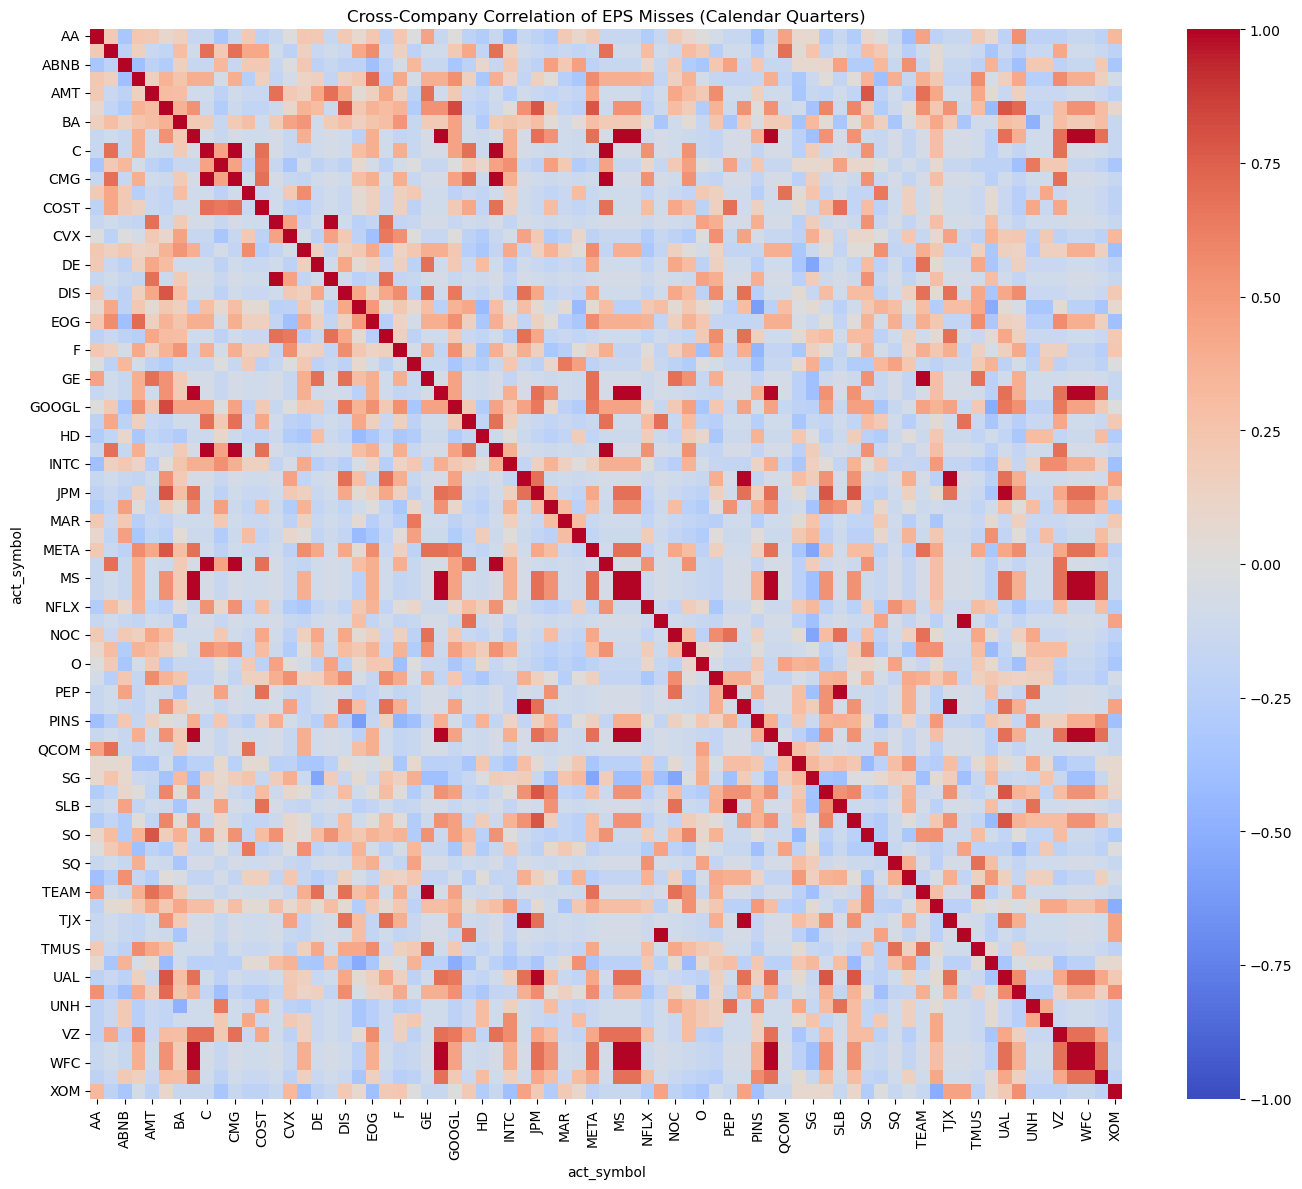

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Start from df_eps which already has:
# - act_symbol
# - period_end_date (datetime)
# - miss (0/1)

# 1. Build a simple beat history dataset
df_hist = df_eps[['act_symbol', 'period_end_date', 'miss']].copy()

# 2. Standardize to calendar year/quarter
df_hist['year'] = df_hist['period_end_date'].dt.year
df_hist['quarter'] = df_hist['period_end_date'].dt.quarter
df_hist['time_index'] = df_hist['year'].astype(str) + '-Q' + df_hist['quarter'].astype(str)

# 3. Keep only tickers with at least 8 quarters of data (2 years)
counts = df_hist['act_symbol'].value_counts()
valid_tickers = counts[counts >= 8].index
df_hist = df_hist[df_hist['act_symbol'].isin(valid_tickers)]

# 4. Pivot: rows = standardized quarters, columns = tickers, values = miss indicator
df_wide = df_hist.pivot(
    index='time_index',
    columns='act_symbol',
    values='miss'
)

# 5. Drop columns with almost no data (fewer than 4 non-NaN observations)
df_wide = df_wide.dropna(axis=1, thresh=4)

# 6. Fill remaining missing values with 0 (treat "no data" as no miss)
df_wide = df_wide.fillna(0)

# 7. Drop tickers that never vary (always 0 or always 1)
varying = df_wide.nunique(axis=0) > 1
df_wide = df_wide.loc[:, varying]

print("Wide matrix shape (quarters, tickers):", df_wide.shape)

# 8. Compute cross-company correlation
company_corr = df_wide.corr()

print("Correlation matrix shape:", company_corr.shape)
company_corr.head()

plt.figure(figsize=(14, 12))
sns.heatmap(company_corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Cross-Company Correlation of EPS Misses (Calendar Quarters)")
plt.tight_layout()
plt.show()

We wanted to understand whether earnings misses tend to happen at the same time across different companies, potentially within similar industries or sectors. After aligning reporting calendars and filtering out companies with limited history or no variation in their earnings results, we calculated correlations in quarterly miss patterns across firms. What we find is that most correlations are quite low, which suggests that earnings misses are usually driven by company-specific factors rather than widespread market or sector dynamics. There are a few clusters where companies show a bit more co-movement, particularly in industries that share direct economic exposures, such as airlines, energy, and certain semiconductor firms. Overall, though, the data shows that misses tend to be isolated events, with only occasional alignment driven by shared external pressures.

In [20]:
counts = df_eps['act_symbol'].value_counts()
removed_low_history = counts[counts < 8]
removed_low_history

Series([], Name: count, dtype: int64)

In [21]:
# Before dropping constant tickers
initial_tickers = set(valid_tickers)

# After filters applied
final_tickers = set(df_wide.columns)

# Constant / non-varying = in initial set but not final set
removed_constant = initial_tickers - final_tickers
removed_constant

{'ABBV',
 'ADBE',
 'ADP',
 'AMD',
 'AVGO',
 'CRWD',
 'CSCO',
 'HON',
 'JNJ',
 'KO',
 'LMT',
 'LOW',
 'LULU',
 'MA',
 'MRK',
 'NEE',
 'NOW',
 'OKTA',
 'PANW',
 'PYPL',
 'RDDT',
 'RTX',
 'V',
 'ZM',
 'ZS'}